Bias and Fairness in Authorial Gender Attribution
--------------------------------------------------------

Code and results used in the following paper:

Corina Koolen, Andreas van Cranenburgh (2017). These are not the Stereotypes You are Looking For: Bias and Fairness in Authorial Gender Attribution. Proceedings of the Ethics in NLP 2017 workshop.

In [1]:
%matplotlib inline
import io
from collections import OrderedDict
import pandas
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import mpld3
import seaborn as sns
from sklearn import preprocessing, pipeline, feature_extraction, feature_selection, model_selection, svm,  metrics

sns.set(style='white', palette='muted')

def readparses(filename):
    """Read parse trees in Negra export format using Pandas."""
    a = pandas.read_table(
            filename, index_col=False, quoting=3, dtype=str,
            usecols=['lemma'], sep='\t')['lemma'].dropna()
    return a[~a.str.startswith('#')]

def evalreport(y, pred, labels):
    """Produce a Latex table with a classification evaluation."""
    labels1 = list(labels) + ['avg / total']
    result = {
        'prec.': pandas.Series([100 * metrics.precision_score(y, pred, average='weighted', labels=[a]) for a in labels]
            + [100 * metrics.precision_score(y, pred, average='weighted')], index=labels1),
        'rec.': pandas.Series([100 * metrics.recall_score(y, pred, average='weighted', labels=[a]) for a in labels]
            + [100 * metrics.recall_score(y, pred, average='weighted', )], index=labels1),
        'F1': pandas.Series([100 * metrics.f1_score(y, pred, average='weighted', labels=[a]) for a in labels]
            + [100 * metrics.f1_score(y, pred, average='weighted')], index=labels1),
        'support': pandas.Series([list(y).count(a) for a in labels] + [len(y)], index=labels1, dtype=int)}
    return pandas.DataFrame(result, columns=['prec.', 'rec.', 'F1', 'support']).round(1).to_latex(float_format='%3.1f')

COLORS = 'Blue Red Black Orange Green Turquoise SlateGray Peru'.split()
def scatterplot(data, x=None, y=None, cat=None, sizecat=None, labels=None,
                alpha=0.5, figsize=(12, 10), markersize=100, graybg=False):
    """Create scatter plot with labels as tooltips shown on mouse-over.
    Input is a dataframe, the other parameters are column names.
    Maximum of 7 categories.
    Usage:
    >>> scatterplot(...)
    >>> mpld3.display()
    """
    fig, ax = plt.subplots(
        subplot_kw=dict(axisbg='#EEEEEE') if graybg else None,
        figsize=figsize)
    # labels for categories:
    target_names = list(set(data[cat]))
    colors = 'rbmkycgw'
    # labels for datapoints:
    if labels is None:
        labels = data.index
    elif isinstance(labels, str):
        labels = data[labels]
    for i, c, a in zip(range(9), COLORS, target_names):
        scatter = ax.scatter(
                data[data[cat] == a][x],
                data[data[cat] == a][y],
                color=c,
                s=markersize if sizecat is None else (5 * data[data[cat] == a][sizecat] ** 2),
                alpha=alpha,
                label=a,
                )
        tooltip = mpld3.plugins.PointLabelTooltip(
                scatter,
                labels=[labels[n] for n in (data[cat] == a).nonzero()[0]])
        mpld3.plugins.connect(fig, tooltip)
    ax.set_xlabel(x); ax.set_ylabel(y);
    # work around limitation of mpld3 wrt markers in legends
    ax.legend(loc='best', framealpha=0, numpoints=1, handles=[
            mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=c, label=a)
            for c, a in zip(COLORS, target_names)])
    return fig

In [2]:
# Riddle corpus
md = pandas.read_csv('Riddle/metadata.csv', index_col=0)
genderdist = pandas.read_csv(
        'Dropbox/accepted/ETH2017/riddlereadergenderdist.csv',
        header=None, index_col=0)[1].sort_values()
# The above was created from the original survey data as follows:
# genderdist = df.loc[df.gender == 'female'].booksread.sum() / df.booksread.sum() * 100
# genderdist = genderdist.loc[genderdist.index != 'NoneOfTheAbove']

# reference/nominees corpus
mdr = pandas.read_csv('Dropbox/accepted/ETH2017/Metadata_refcorpus.csv', index_col='Label').rename(
        columns={'Gender author': 'Author gender'})
# note: we re-annotate one novel by Februari from 'transgender male' to 'male' for simplicity.
mdr['Author gender'].replace(['f', 'm', 'tm'], ['female', 'male', 'male'], inplace=True)

Riddle corpus stats
----------------------

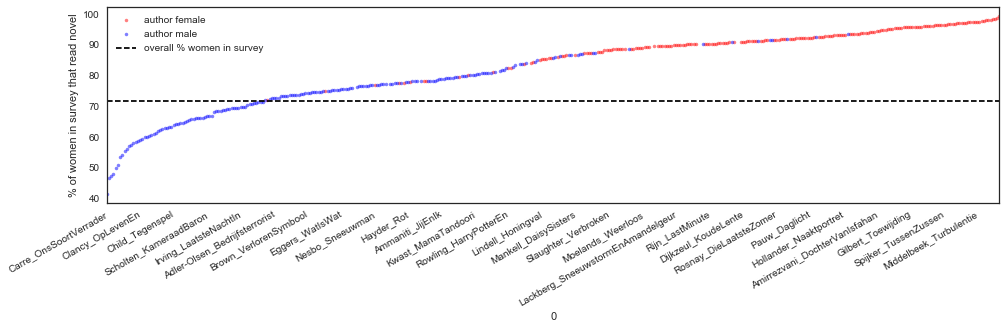

In [3]:
# Riddle survey reader gender distribution
ax = pandas.Series(genderdist.loc[md[md['Author gender'] == 'female'].index], index=genderdist.index).plot(
    figsize=(16, 4), linestyle='None', marker='.', xticks=range(0, 401, 20), color='red',  alpha=0.5,
    label='author female')
pandas.Series(genderdist.loc[md[md['Author gender'] == 'male'].index], index=genderdist.index).plot(
    ax=ax, linestyle='None', marker='.', xticks=range(1, 401, 15), color='blue', alpha=0.5,
    label='author male')
ax.plot([0, 401], [71.791011, 71.791011], linestyle='dashed', color='black',
        label='overall % women in survey');
ax.set_ylabel('% of women in survey that read novel')
ax.figure.autofmt_xdate();
ax.legend(loc='upper left');

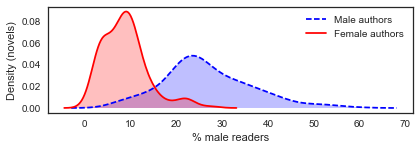

In [4]:
md['% female readers'] = genderdist
fig = plt.figure(figsize=(6, 2.25))
ax = plt.gca()
sns.kdeplot(100 - md[md['Author gender'] == 'male']['% female readers'],
                 color='blue', label='Male authors', shade=True, linestyle='dashed', ax=ax);
sns.kdeplot(100 - md[md['Author gender'] == 'female']['% female readers'],
            color='red', label='Female authors', shade=True, ax=ax);
ax.legend(loc='best')
ax.set_xlabel('% male readers');
ax.set_ylabel('Density (novels)');
fig.tight_layout()
# fig.savefig('Dropbox/accepted/ETH2017/kdereaders.pdf')

In [5]:
# Percentages for genres
md.Category.value_counts() / len(md) * 100

Suspense    46.384040
Fiction     36.907731
Romantic    10.224439
Other        6.483791
Name: Category, dtype: float64

In [6]:
# Percentages for author genders
md['Author gender'].value_counts() / len(md) * 100

female              48.877805
male                47.630923
unknown/multiple     3.491272
Name: Author gender, dtype: float64

In [7]:
# Distribution of gender vs translated for Literary novels
md[md.Category == 'Fiction'].Translated.str.cat(md[md.Category == 'Fiction']['Author gender'], sep=', ').value_counts()

no, male                50
yes, male               40
yes, female             34
no, female              23
no, unknown/multiple     1
Name: Translated, dtype: int64

LIWC tests & plots
------------

In [8]:
refliwc = pandas.read_excel('Dropbox/accepted/ETH2017/LIWCreviews_novels_comparison.xlsx',
        sheetname='Novels', index_col='Filename').rename(columns={'Gender author': 'Author gender'})
refliwc = refliwc.iloc[:50]  # 50 novels, skip totals after that
refliwc.index = refliwc.index.str.replace('\.txt$', '')
refliwc['Author gender'] = mdr['Author gender']
refliwc.columns

Index(['Author gender', 'Segment', 'Pronoun', 'I', 'We', 'Self', 'You',
       'Other', 'Negate', 'Assent', 'Article', 'Preps', 'Number', 'Affect',
       'Posemo', 'Posfeel', 'Optim', 'Negemo', 'Anx', 'Anger', 'Sad',
       'Cogmech', 'Cause', 'Insight', 'Discrep', 'Inhib', 'Tentat', 'Certain',
       'Senses', 'See', 'Hear', 'Feel', 'Social', 'Comm', 'Othref', 'Friends',
       'Family', 'Humans', 'Time', 'Past', 'Present', 'Future', 'Space', 'Up',
       'Down', 'Incl', 'Excl', 'Motion', 'Occup', 'School', 'Job', 'Achieve',
       'Leisure', 'Home', 'Sports', 'TV', 'Music', 'Money', 'Metaph', 'Relig',
       'Death', 'Physcal', 'Body', 'Sexual', 'Eating', 'Sleep', 'Groom',
       'Swear', 'Nonfl', 'Fillers'],
      dtype='object')

In [9]:
riddleliwc = pandas.read_excel('Dropbox/accepted/ETH2017/allnovels.xlsx',
        sheet='allnovels', index_col='Filename', skiprows=[1]).rename(
        columns={'Gender auteur': 'Author gender'})
riddleliwc.index = riddleliwc.index.str.replace('\.txt$', '')
riddleliwc['Author gender'] = md['Author gender']
riddleliwc.columns

Index(['SurveyID', 'Categorie', 'Riddle-code', 'Vertaling', 'Author gender',
       'gendsim', 'Segment', 'WC', 'WPS', 'Pronoun', 'I', 'We', 'Self', 'You',
       'Other', 'Negate', 'Assent', 'Article', 'Preps', 'Number', 'Affect',
       'Posemo', 'Posfeel', 'Optim', 'Negemo', 'Anx', 'Anger', 'Sad',
       'Cogmech', 'Cause', 'Insight', 'Discrep', 'Inhib', 'Tentat', 'Certain',
       'Senses', 'See', 'Hear', 'Feel', 'Social', 'Comm', 'Othref', 'Friends',
       'Family', 'Humans', 'Time', 'Past', 'Present', 'Future', 'Space', 'Up',
       'Down', 'Incl', 'Excl', 'Motion', 'Occup', 'School', 'Job', 'Achieve',
       'Leisure', 'Home', 'Sports', 'TV', 'Music', 'Money', 'Metaph', 'Relig',
       'Death', 'Physcal', 'Body', 'Sexual', 'Eating', 'Sleep', 'Groom',
       'Swear'],
      dtype='object')

In [10]:
def cohen_d(x, y):
    # http://stackoverflow.com/a/33002123/338811
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return ((x.mean() - y.mean())
            / ((((nx - 1) * x.std(ddof=1) ** 2
                 + (ny - 1) * y.std(ddof=1) ** 2) / dof) ** 0.5))

def sigtest(df, alpha):
    # Run t-tests with FDR correction
    columns = ['Pronoun', 'I', 'We', 'Self', 'You', 'Other', 'Negate', 'Assent', 'Article', 'Preps',
       'Number', 'Affect', 'Posemo', 'Posfeel', 'Optim', 'Negemo', 'Anx',
       'Anger', 'Sad', 'Cogmech', 'Cause', 'Insight', 'Discrep', 'Inhib',
       'Tentat', 'Certain', 'Senses', 'See', 'Hear', 'Feel', 'Social', 'Comm',
       'Othref', 'Friends', 'Family', 'Humans', 'Time', 'Past', 'Present',
       'Future', 'Space', 'Up', 'Down', 'Incl', 'Excl', 'Motion', 'Occup',
       'School', 'Job', 'Achieve', 'Leisure', 'Home', 'Sports', 'TV', 'Music',
       'Money', 'Metaph', 'Relig', 'Death', 'Physcal', 'Body', 'Sexual',
       'Eating', 'Sleep', 'Groom', 'Swear']
    transform = feature_selection.SelectFdr(score_func=feature_selection.f_classif, alpha=alpha)
    df = df.loc[(df['Author gender'] == 'male') | (df['Author gender'] == 'female')]
    transform.fit(df[columns].values, df['Author gender'])
    result = pandas.DataFrame(
        OrderedDict([
             # ('uncorr. p-value', pandas.Series(transform.pvalues_, index=columns)),
             ('mean F', df.loc[df['Author gender'] == 'female', columns].mean()),
             ('std F', df.loc[df['Author gender'] == 'female', columns].std()),
             ('mean M', df.loc[df['Author gender'] == 'male', columns].mean()),
             ('std M', df.loc[df['Author gender'] == 'male', columns].std()),
             ('effect size (d)', [cohen_d(
                 df.loc[df['Author gender'] == 'female', a],
                 df.loc[df['Author gender'] == 'male', a]) for a in columns]),
            ('sign.', ['*' if a else '' for a in transform._get_support_mask()]),
        ]))
    return result, (result['sign.'] == '*').sum()

In [11]:
res, numsig = sigtest(riddleliwc, 0.01)
print(res.round(2).sort_values(by='effect size (d)'))
print('# significant after correction:', numsig)

         mean F  std F  mean M  std M  effect size (d) sign.
Article    8.48   1.08    9.71   1.19            -1.08     *
Number     0.61   0.15    0.79   0.25            -0.86     *
Space      1.77   0.23    1.96   0.25            -0.78     *
Occup      0.54   0.15    0.67   0.20            -0.75     *
Job        0.29   0.11    0.39   0.19            -0.67     *
Preps     11.38   0.86   11.92   0.86            -0.63     *
Incl       6.33   0.53    6.60   0.56            -0.50     *
Achieve    0.10   0.04    0.12   0.06            -0.48     *
Past       6.98   3.06    8.17   2.21            -0.44     *
Up         1.29   0.15    1.35   0.16            -0.40     *
Sports     0.07   0.03    0.09   0.05            -0.39     *
TV         0.02   0.02    0.03   0.03            -0.30     *
Down       0.12   0.04    0.13   0.05            -0.30     *
Death      0.13   0.09    0.14   0.08            -0.21      
We         0.20   0.16    0.23   0.18            -0.18      
Money      0.20   0.10  

In [12]:
print(res.loc[['Pronoun', 'Article', 'Preps', 'Number',
         'Affect', 'Negate', 'Posemo',
         'Cogmech', 'Social', 'Friends', 'Humans', 'Occup', 'Home',
         'Money', 'Body']].round(2).to_latex())

\begin{tabular}{lrrrrrl}
\toprule
{} &  mean F &  std F &  mean M &  std M &  effect size (d) & sign. \\
\midrule
Pronoun &   12.58 &   1.90 &   10.14 &   2.10 &             1.22 &     * \\
Article &    8.48 &   1.08 &    9.71 &   1.19 &            -1.08 &     * \\
Preps   &   11.38 &   0.86 &   11.92 &   0.86 &            -0.63 &     * \\
Number  &    0.61 &   0.15 &    0.79 &   0.25 &            -0.86 &     * \\
Affect  &    2.84 &   0.49 &    2.35 &   0.38 &             1.12 &     * \\
Negate  &    2.02 &   0.31 &    1.78 &   0.35 &             0.74 &     * \\
Posemo  &    1.38 &   0.34 &    1.13 &   0.23 &             0.86 &     * \\
Cogmech &    5.51 &   0.67 &    5.03 &   0.72 &             0.69 &     * \\
Social  &   10.81 &   2.00 &    9.54 &   1.73 &             0.68 &     * \\
Friends &    0.10 &   0.04 &    0.09 &   0.04 &             0.23 &       \\
Humans  &    0.43 &   0.16 &    0.41 &   0.15 &             0.11 &       \\
Occup   &    0.54 &   0.15 &    0.67 &   0.20 &   

In [13]:
res, numsig = sigtest(refliwc, 0.01)
#print(res.round(2))
print(res.loc[['Pronoun', 'Article', 'Preps', 'Number',
         'Affect', 'Negate', 'Posemo',
         'Cogmech', 'Social', 'Friends', 'Humans', 'Occup', 'Home',
         'Money', 'Body', 'Anger']].round(2).to_latex())
print('# significant after correction:', numsig)

\begin{tabular}{lrrrrrl}
\toprule
{} &  mean F &  std F &  mean M &  std M &  effect size (d) & sign. \\
\midrule
Pronoun &   11.29 &   2.19 &    9.92 &   2.09 &             0.64 &       \\
Article &    9.82 &   1.37 &   10.23 &   1.01 &            -0.34 &       \\
Preps   &   11.73 &   1.19 &   12.19 &   1.03 &            -0.42 &       \\
Number  &    0.64 &   0.16 &    0.67 &   0.16 &            -0.23 &       \\
Affect  &    2.55 &   0.47 &    2.25 &   0.36 &             0.70 &       \\
Negate  &    2.03 &   0.39 &    1.70 &   0.34 &             0.90 &       \\
Posemo  &    1.26 &   0.23 &    1.06 &   0.19 &             0.96 &       \\
Cogmech &    5.01 &   0.69 &    4.50 &   0.64 &             0.76 &       \\
Social  &    9.72 &   2.39 &    8.79 &   2.05 &             0.42 &       \\
Friends &    0.10 &   0.05 &    0.07 &   0.03 &             0.79 &       \\
Humans  &    0.44 &   0.13 &    0.44 &   0.19 &             0.03 &       \\
Occup   &    0.56 &   0.17 &    0.56 &   0.21 &   

In [14]:
def kde(df1, df2, cat):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2), sharex=True, sharey=True)
    for ax, df, label in zip(axes, (df1, df2), ('Riddle', 'Nominees')):
        sns.kdeplot(df[df['Author gender'] == 'male'][cat], label='male', shade=True, ax=ax, linestyle='dashed')
        sns.kdeplot(df[df['Author gender'] == 'female'][cat], label='female', shade=True, ax=ax, color='r')
        ax.set_title(label + ': ' + cat)
        ax.set_xlabel('% words')
        ax.legend(loc='best')
    axes[0].set_ylabel('density (texts)')
    return fig

In [15]:
riddleliwc['Author gender'].value_counts()

female              186
male                183
unknown/multiple     14
Name: Author gender, dtype: int64

In [16]:
refliwc['Author gender'].value_counts()

male      26
female    24
Name: Author gender, dtype: int64

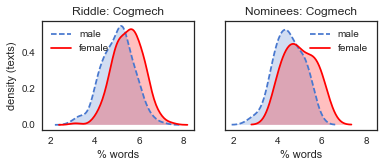

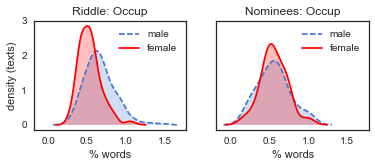

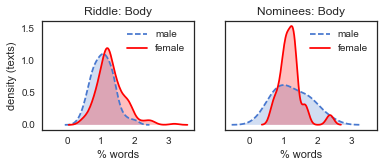

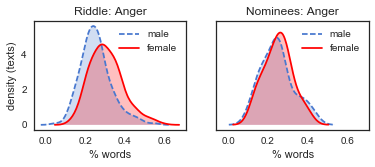

In [17]:
for cat in ('Cogmech', 'Occup', 'Body', 'Anger'):
    fig = kde(riddleliwc, refliwc, cat)
    # fig.savefig('Dropbox/accepted/ETH2017/kde%s.pdf' % cat.lower())

Classification (SVM)
-----------------------

In [18]:
vectorizer = feature_extraction.text.CountVectorizer(min_df=0.4)
data = (' '.join(readparses('Riddle/parses/%s.export' % label))
            for label in md[md['Author gender'] != 'unknown/multiple'].index)
X = vectorizer.fit_transform(data)

data = (' '.join(readparses('Riddle/reference/parses/%s.export' % label))
            for label in mdr.index)
XX = vectorizer.transform(data)

In [19]:
le = preprocessing.LabelEncoder()
y = md[md['Author gender'] != 'unknown/multiple']['Author gender']
yt = le.fit_transform(y)
authors = y.index.str.split('_').str[0]
cv = model_selection.GroupKFold(n_splits=5)
model = pipeline.Pipeline([
    ('tfidf', feature_extraction.text.TfidfTransformer(use_idf=False)),
    ('svm', svm.LinearSVC(C=200, random_state=1))])
pred = model_selection.cross_val_predict(model, X, yt, cv=cv, groups=authors)
md.loc[md['Author gender'] != 'unknown/multiple', 'pred'] = le.inverse_transform(pred)
md.to_csv('Dropbox/accepted/ETH2017/predriddle.csv')
print(evalreport(y, le.inverse_transform(pred), le.classes_))

\begin{tabular}{lrrrr}
\toprule
{} &  prec. &  rec. &   F1 &  support \\
\midrule
female      &   81.0 &  86.7 & 83.7 &      196 \\
male        &   85.3 &  79.1 & 82.1 &      191 \\
avg / total &   83.1 &  82.9 & 82.9 &      387 \\
\bottomrule
\end{tabular}



In [20]:
model.fit(X, yt)
yy = mdr['Author gender']
yyt = le.transform(yy)
pred2 = model.predict(XX)
mdr['pred'] = le.inverse_transform(pred2)
mdr.to_csv('Dropbox/accepted/ETH2017/predref.csv')
print(evalreport(yy, le.inverse_transform(pred2), le.classes_))

\begin{tabular}{lrrrr}
\toprule
{} &  prec. &  rec. &   F1 &  support \\
\midrule
female      &   85.7 &  50.0 & 63.2 &       24 \\
male        &   66.7 &  92.3 & 77.4 &       26 \\
avg / total &   75.8 &  72.0 & 70.6 &       50 \\
\bottomrule
\end{tabular}



In [21]:
print(pandas.DataFrame(metrics.confusion_matrix(y, le.inverse_transform(pred)),
                       index=le.classes_, columns=le.classes_).to_latex())
print(pandas.DataFrame(metrics.confusion_matrix(yy, le.inverse_transform(pred2)),
                       index=le.classes_, columns=le.classes_).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  female &  male \\
\midrule
female &     170 &    26 \\
male   &      40 &   151 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
{} &  female &  male \\
\midrule
female &      12 &    12 \\
male   &       2 &    24 \\
\bottomrule
\end{tabular}



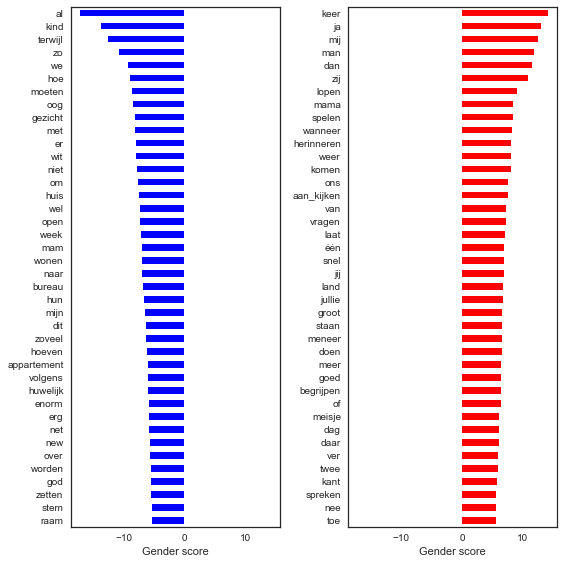

In [22]:
# Plot features with largest weights
features = pandas.Series(model.steps[1][1].coef_[0], index=vectorizer.get_feature_names())
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(8, 8))
features.sort_values().head(40)[::-1].plot(ax=ax1, kind='barh', color='b', label='predictive of male author')
features.sort_values().tail(40).plot(ax=ax2, kind='barh', color='r', label='predictive of female author')
ax1.set_xlabel('Gender score'); ax2.set_xlabel('Gender score')
fig.tight_layout()
fig.savefig('Dropbox/accepted/ETH2017/featcmp.pdf')

In [23]:
# Investigate features by LIWC categories
import re2
macros = {line.split('=', 1)[0]: re2.compile(line.split('=', 1)[1].strip())
              for line in open('disco-dop/web/static/regexmacros.liwc.txt')}
result = {a: features.loc[[x for x in features.index if b.match(x)]] for a, b in macros.items()}
sorted(macros)

['01_Pronoun',
 '02_I',
 '03_We',
 '04_Self',
 '05_You',
 '06_Other',
 '07_Negate',
 '08_Assent',
 '09_Article',
 '10_Preps',
 '11_Number',
 '12_Affect',
 '13_Posemo',
 '14_Posfeel',
 '15_Optim',
 '16_Negemo',
 '17_Anx',
 '18_Anger',
 '19_Sad',
 '20_Cogmech',
 '21_Cause',
 '22_Insight',
 '23_Discrep',
 '24_Inhib',
 '25_Tentat',
 '26_Certain',
 '27_Senses',
 '28_See',
 '29_Hear',
 '30_Feel',
 '31_Social',
 '32_Comm',
 '33_Othref',
 '34_Friends',
 '35_Family',
 '36_Humans',
 '37_Time',
 '38_Past',
 '39_Present',
 '40_Future',
 '41_Space',
 '42_Up',
 '43_Down',
 '44_Incl',
 '45_Excl',
 '46_Motion',
 '47_Occup',
 '48_School',
 '49_Job',
 '50_Achieve',
 '51_Leisure',
 '52_Home',
 '53_Sports',
 '54_TV',
 '55_Music',
 '56_Money',
 '57_Metaph',
 '58_Relig',
 '59_Death',
 '60_Physcal',
 '61_Body',
 '62_Sexual',
 '63_Eating',
 '64_Sleep',
 '65_Groom',
 '66_Swear']

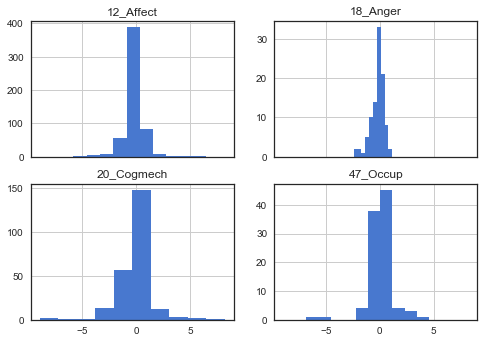

In [24]:
fig, axes = plt.subplots(2, 2, sharex=True)
for a, ax in zip(['12_Affect', '18_Anger', '20_Cogmech', '47_Occup', '61_Body'], axes.flatten()):
    result[a].hist(ax=ax)
    ax.set_title(a)

In [25]:
# Investigate word frequency differences
bow = pandas.DataFrame(
        XX.todense(),
        index=mdr.index,
        columns=vectorizer.get_feature_names())
bow['Author gender'] = mdr['Author gender']
bow = bow.sort_values(by='Author gender').reset_index().set_index(['Author gender', 'Label'])

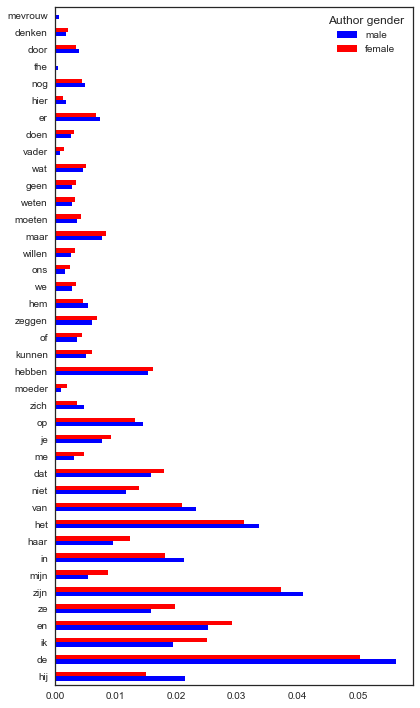

In [26]:
# NB this is a macro average
relfreq = bow.sum(level=0).T / bow.sum(level=0).sum(axis=1)
relfreq['diff'] = (relfreq.male - relfreq.female).abs()
ax = relfreq.sort_values(by='diff', ascending=False).head(40)[['male', 'female']].plot(
        kind='barh', figsize=(6, 10), color=['b', 'r'])
ax.figure.tight_layout()
ax.figure.savefig('Dropbox/accepted/ETH2017/worddiff.pdf')

In [27]:
minfreq = 100; maxfreq = 500
relfreq['diff'] = (relfreq.male - relfreq.female)
x = (relfreq.sort_values(by='female', ascending=False).iloc[minfreq:maxfreq]
        .sort_values(by='diff', ascending=True)[['male', 'female']])
#print('most frequent/distinctive female features\n', (100 * x).head(10).round(4).to_latex(), sep='')
print('most frequent/distinctive female features\n', ', '.join(x.head(10).index), sep='')
x = (relfreq.sort_values(by='female', ascending=False).iloc[minfreq:maxfreq]
        .sort_values(by='diff', ascending=False)[['male', 'female']])
#print('\nmost frequent/distinctive male features\n', (100 * x).head(10).round(4).to_latex(), sep='')
print('\nmost frequent/distinctive male features\n', ', '.join(x.head(10).index), sep='')
#ax = x.plot(kind='barh', figsize=(6, 10), color=['b', 'r']))
#ax.figure.tight_layout()

most frequent/distinctive female features
altijd, mogen, jij, dochter, omdat, alsof, toon, broer, roos, kind

most frequent/distinctive male features
jongen, deze, twee, ver, gezicht, laat, onder, lopen, terug, zwart


In [28]:
relfreq['weight'] = features
relfreq.sort_values('weight', ascending=False).to_csv('/tmp/topfeatures.csv')

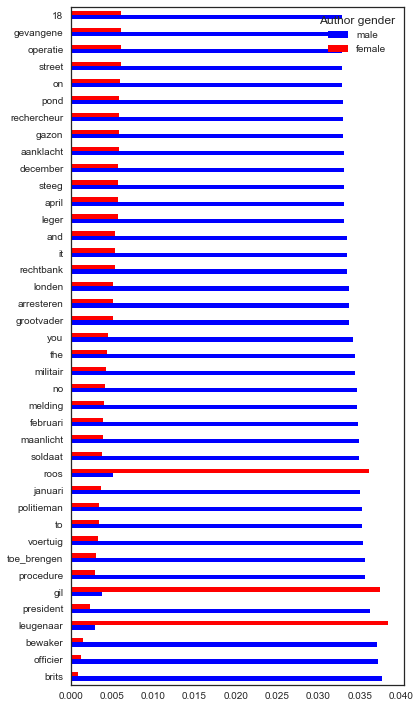

In [29]:
#NB this is a micro average (not useful, too sensitive on outliers)
relfreq = (bow / bow.sum(axis=0)).mean(level=0).T
relfreq['diff'] = (relfreq.male - relfreq.female).abs()
ax = relfreq.sort_values(by='diff', ascending=False).head(40)[['male', 'female']].plot(
        kind='barh', figsize=(6, 10), color=['b', 'r'])
ax.figure.tight_layout()

In [30]:
# character 3-grams
cvectorizer = feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3, 3))
data = (open('Riddle/tokenized/%s.tok' % label).read()
            for label in md[md['Author gender'] != 'unknown/multiple'].index)
Xc = cvectorizer.fit_transform(data)

data = (open('Riddle/reference/tokenized/%s.tok' % label).read()
            for label in mdr.index)
XXc = cvectorizer.transform(data)

In [31]:
le = preprocessing.LabelEncoder()
y = md[md['Author gender'] != 'unknown/multiple']['Author gender']
yt = le.fit_transform(y)
authors = y.index.str.split('_').str[0]
cv = model_selection.GroupKFold(n_splits=5)
model = pipeline.Pipeline([
    ('tfidf', feature_extraction.text.TfidfTransformer(use_idf=False)),
    ('svm', svm.LinearSVC(C=200, random_state=1))])
pred = model_selection.cross_val_predict(model, Xc, yt, cv=cv, groups=authors)
md.loc[md['Author gender'] != 'unknown/multiple', 'pred'] = le.inverse_transform(pred)
md.to_csv('Dropbox/accepted/ETH2017/predriddle.csv')
print(evalreport(y, le.inverse_transform(pred), le.classes_))

\begin{tabular}{lrrrr}
\toprule
{} &  prec. &  rec. &   F1 &  support \\
\midrule
female      &   80.0 &  81.6 & 80.8 &      196 \\
male        &   80.7 &  79.1 & 79.9 &      191 \\
avg / total &   80.4 &  80.4 & 80.4 &      387 \\
\bottomrule
\end{tabular}



In [32]:
model.fit(Xc, yt)
yy = mdr['Author gender']
yyt = le.transform(yy)
pred2 = model.predict(XXc)
mdr['pred'] = le.inverse_transform(pred2)
mdr.to_csv('Dropbox/accepted/ETH2017/predref.csv')
print(evalreport(yy, le.inverse_transform(pred2), le.classes_))

\begin{tabular}{lrrrr}
\toprule
{} &  prec. &  rec. &   F1 &  support \\
\midrule
female      &   78.6 &  45.8 & 57.9 &       24 \\
male        &   63.9 &  88.5 & 74.2 &       26 \\
avg / total &   70.9 &  68.0 & 66.4 &       50 \\
\bottomrule
\end{tabular}



Topic Model (LDA)
--------------------

In [33]:
topicsriddle = pandas.read_table('Dropbox/Riddle/DH2016/doctopics.txt',
        index_col=0, header=None, usecols=range(1, 52),
        names=['Filename'] + ['t%d' % n for n in range(50)]).fillna(0).sort_index()
split = topicsriddle.index.str.split('.export_')
topicsriddle['Label'] = split.str.get(0)
topicsriddle['chunk'] = split.str.get(1)
topicsriddle = topicsriddle.reset_index(drop=True).set_index(['Label', 'chunk'])
topicsriddle['gender'] = [''] * len(topicsriddle)
for a, b in md['Author gender'].iteritems():
    topicsriddle.loc[a, 'gender'] = b
topicsriddle = topicsriddle[topicsriddle['gender'] != '']
topicsriddle

t0        t1        t2        t3        t4  \
Label           chunk                                                     
Abdolah_Koning  000    0.000067  0.016340  0.095689  0.000021  0.000119   
                001    0.000066  0.089055  0.042211  0.000021  0.000118   
                002    0.000072  0.112973  0.099301  0.005985  0.000128   
                003    0.000069  0.040998  0.000305  0.018380  0.000123   
                004    0.000069  0.044187  0.057347  0.000021  0.000122   
                005    0.000067  0.088637  0.050322  0.000021  0.000119   
                006    0.001208  0.094278  0.153006  0.047883  0.008099   
                007    0.000069  0.069604  0.023226  0.000021  0.000123   
                008    0.001215  0.079919  0.002596  0.000021  0.000123   
                009    0.000069  0.036450  0.004900  0.000021  0.018503   
                010    0.018407  0.042097  0.000304  0.000021  0.073473   
                011    0.000068  0.078834  0.000300  0.000021  0.000121   
                012    0.000068  0.154323  0.037822  0.018213  0.000122   
                013    0.000069  0.045745  0.039453  0.000021  0.000123   
                014    0.000068  0.023384  0.055572  0.000021  0.004633   
                015    0.000070  0.196516  0.004997  0.018768  0.001297   
                016    0.000068  0.118942  0.075257  0.040906  0.000121   
                017    0.000067  0.066551  0.000296  0.000021  0.010147   
                018    0.000068  0.115012  0.009345  0.000021  0.000121   
                019    0.000068  0.103942  0.003700  0.000021  0.000121   
                020    0.000069  0.048974  0.063340  0.000021  0.000123   
                021    0.000070  0.080939  0.022362  0.000022  0.000124   
                022    0.000070  0.112291  0.010868  0.000022  0.000125   
                023    0.000067  0.095992  0.012468  0.000021  0.000118   
                024    0.000068  0.008740  0.019520  0.064463  0.000121   
                025    0.000068  0.053719  0.068952  0.000021  0.000120   
                026    0.006634  0.078521  0.000291  0.000020  0.004496   
                027    0.000067  0.040970  0.010335  0.000021  0.000119   
                028    0.022782  0.181405  0.042322  0.062484  0.000121   
                029    0.000069  0.060713  0.009517  0.000021  0.000123   
...                         ...       ...       ...       ...       ...   
Zwaan_Parnassia 022    0.000070  0.025194  0.007264  0.000022  0.067369   
                023    0.037918  0.036345  0.048805  0.000022  0.037973   
                024    0.000073  0.038484  0.040345  0.000023  0.055920   
                025    0.014230  0.140092  0.067568  0.000022  0.000126   
                026    0.000073  0.079817  0.088966  0.000023  0.000130   
                027    0.000072  0.194500  0.070071  0.000022  0.000129   
                028    0.002480  0.162224  0.130359  0.000022  0.000129   
                029    0.000068  0.047555  0.059560  0.000021  0.000122   
                030    0.000070  0.014725  0.003777  0.000022  0.000124   
                031    0.000070  0.066311  0.000310  0.026906  0.015320   
                032    0.000071  0.055268  0.015689  0.000022  0.000126   
                033    0.000070  0.057027  0.036588  0.000022  0.108958   
                034    0.000068  0.020205  0.000302  0.000021  0.045705   
                035    0.005992  0.015074  0.000314  0.000022  0.000127   
                036    0.000071  0.017422  0.065363  0.000022  0.000126   
                037    0.000365  0.004440  0.050240  0.000113  0.000650   
Zwagerman_Duel  000    0.000067  0.045482  0.000296  0.000021  0.000119   
                001    0.000066  0.020685  0.000293  0.000021  0.000118   
                002    0.000067  0.007474  0.009179  0.000021  0.000119   
                003    0.000073  0.016572  0.000320  0.000023  0.006164   
                004    0.000073  0.116813  0.000324  0

In [34]:
topicsref = pandas.read_table('Riddle/reference/lda/doctopics.txt',
        index_col=0, header=None, usecols=range(1, 52), skiprows=1,
        names=['Filename'] + ['t%d' % n for n in range(50)]).fillna(0).sort_index()
split = topicsref.index.str.split('.export_')
topicsref['Label'] = split.str.get(0)
topicsref['chunk'] = split.str.get(1)
topicsref = topicsref.reset_index(drop=True).set_index(['Label', 'chunk'])
topicsref['gender'] = [''] * len(topicsref)
for a, b in mdr['Author gender'].iteritems():
    topicsref.loc[a, 'gender'] = b
topicsref = topicsref[topicsref['gender'] != '']  # drop duplicate "deUtopisten", and an empty line
topicsref

t0        t1        t2        t3  \
Label                    chunk                                           
Aalten_Schuldigen        000    0.005047  0.014432  0.060399  0.000035   
                         001    0.009439  0.055942  0.052073  0.000058   
                         002    0.022930  0.012911  0.033446  0.000034   
                         003    0.000466  0.008795  0.044928  0.000046   
                         004    0.000268  0.009047  0.055958  0.004847   
                         005    0.000619  0.003022  0.006063  0.000560   
                         006    0.001694  0.050277  0.006110  0.000160   
                         007    0.001371  0.113648  0.001304  0.000317   
                         008    0.000633  0.032776  0.001917  0.004077   
                         009    0.000492  0.039734  0.002503  0.000275   
                         010    0.000849  0.007168  0.057415  0.000273   
                         011    0.000899  0.037200  0.004240  0.000259   
                         012    0.000826  0.058680  0.011715  0.000046   
                         013    0.041790  0.007275  0.001474  0.000046   
                         014    0.044936  0.034004  0.013346  0.000057   
                         015    0.011823  0.034120  0.012770  0.000107   
                         016    0.000501  0.027278  0.001606  0.001393   
                         017    0.000399  0.006510  0.002745  0.000081   
                         018    0.002011  0.024358  0.017479  0.000934   
                         019    0.001782  0.075839  0.021161  0.000034   
                         020    0.012023  0.010412  0.004906  0.000184   
                         021    0.000196  0.041217  0.002724  0.000276   
                         022    0.000222  0.006800  0.026896  0.000080   
                         023    0.002992  0.004922  0.008160  0.000427   
                         024    0.001201  0.005886  0.033381  0.000057   
                         025    0.004037  0.009624  0.052936  0.000058   
                         026    0.008090  0.102459  0.077025  0.000022   
                         027    0.016536  0.086872  0.084969  0.000482   
Bossenbroek_Boerenoorlog 000    0.000250  0.144757  0.016954  0.000135   
                         001    0.000390  0.152938  0.006763  0.000110   
...                                  ...       ...       ...       ...   
Wieringa_DitZijnNamen    001    0.021535  0.008317  0.044741  0.000056   
                         002    0.000863  0.057224  0.008604  0.000033   
                         003    0.014509  0.036074  0.014908  0.000126   
                         004    0.001171  0.023550  0.026146  0.009574   
                         005    0.000398  0.025640  0.012377  0.021009   
                         006    0.000373  0.028993  0.002828  0.039608   
                         007    0.000294  0.037423  0.014013  0.001343   
                         008    0.001917  0.017938  0.027164  0.001120   
                         009    0.006632  0.027323  0.053902  0.000216   
                         010    0.001972  0.056663  0.051244  0.000254   
                         011    0.001085  0.080740  0.019936  0.000360   
                         012    0.000406  0.077162  0.075781  0.000664   
                         013    0.001561  0.022799  0.023409  0.001055   
                         014    0.003056  0.134317  0.047800  0.000318   
                         015    0.002629  0.137025  0.059390  0.003303   
                         016    0.002713  0.056106  0.005347  0.000425   
                         017    0.000319  0.070561  0.015229  0.004323   
                         018    0.000495  0.061870  0.005912  0.000210   
                         019    0.000520  0.018644  0.005547  0.000494   
                         020    0.001861  0.063035  0.001358  0.002366   
                         021    0.001041  0.110987  0.005440  0.009434   
                         022    0.001480  

In [35]:
# Note: the topic model is based on chunks of 1000 lemmas,
# which is why these counts are larger than the number of novels.
topicsriddle['gender'].value_counts()

male                9183
female              8262
unknown/multiple     618
Name: gender, dtype: int64

In [36]:
topicsref['gender'].value_counts()

male      1097
female     791
Name: gender, dtype: int64

In [37]:
topicnames = pandas.read_table(io.StringIO("""\
Topic	Proportion	Category	Label	Other
t0	1.60%	suspense	spy fiction	
t1	8.80%	other	self-development	
t2	2.70%	literary	family	
t3	0.50%	other	author: Auel	misc
t4	1.50%	theme	sex	
t5	1.10%	suspense	lawsuits	
t6	0.70%	theme	illness	
t7	2.10%	theme	country side	
t8	0.40%	theme	quotation/communication	
t9	2.00%	theme	house	
t10	1.70%	suspense	murder case	
t11	1.60%	theme	children	
t12	1.80%	theme	letters	
t13	0.90%	suspense	investigation	Scandinavian
t14	1.10%	suspense	non-verbal communication	Scandinavian
t15	1.90%	theme	telephony	
t16	1.60%	suspense	interrogatory	Swedish
t17	1.60%	other	author: Den Hollander	
t18	1.10%	theme	maritime	Cussler
t19	0.60%	literary	rulers	
t20	2.60%	romantic	body language	Dutch
t21	1.90%	theme	travel	
t22	2.30%	suspense	murder case	
t23	3.90%	theme	settling down	
t24	0.80%	theme	mystery/archeology	
t25	5.30%	theme	physical attack	
t26	3.40%	literary	nature/life	
t27	1.40%	theme	finance	
t28	0.50%	theme	fantasy	
t29	1.30%	literary	music/performance/misc	Dutch
t30	1.00%	theme	education	
t31	5.80%	theme	(non-)verbal communication	
t32	1.80%	theme	company	
t33	0.60%	theme	hospital	
t34	2.00%	theme	cars	
t35	0.90%	theme	church	
t36	1.50%	theme	international politics	
t37	0.70%	theme	military	
t38	0.60%	literary	slavery & inter-human relations	
t39	1.80%	suspense	weapons	
t40	1.60%	theme	dinner	
t41	1.60%	literary	writers	
t42	1.50%	literary	time, life&death	
t43	0.50%	literary	jewishness	
t44	2.50%	romantic	looks & parties	
t45	3.30%	theme	communication2	
t46	0.70%	other	author: Kinsella/Wickham	?
t47	3.30%	theme	character & bodily descriptions	
t48	6.30%	other	dialogues/colloquial language	
t49	3.10%	theme	home	\
"""), header=0, index_col=0)
topiclongnames = dict(zip(topicnames.index, topicnames.index + ': ' + topicnames.Label))

In [38]:
meantopicsref = topicsref.reset_index().set_index(['gender','Label', 'chunk'], drop=False).mean(level=0).T
meantopicsref.index = topicnames.index + ': ' + topicnames.Label
meantopicsref['diff'] = (meantopicsref.male - meantopicsref.female).abs()

meantopicsriddle = topicsriddle.reset_index().set_index(['gender','Label', 'chunk'], drop=False).mean(level=0).T
meantopicsriddle.index = topicnames.index + ': ' + topicnames.Label
meantopicsriddle['diff'] = (meantopicsriddle.male - meantopicsriddle.female).abs()

topicgloss = {
        't2': 'father mother child year son',
        't37': 'soldier lieutenant army two to-get',
        't23': 'life house child woman year',
        't48': 'simply totally to-tell time of-course',
        't1': 'life time human moment stay',
        #
        't14': 'man few to-get time to-nod',
        't46': 'mom suddenly just to-get to-feel',
        't44': 'woman glass dress nice to-look',
        't9': 'house wall old to-lie to-hang',
        't8': 'madam grandma old to-tell to-hear',
}

def toptopicplot(x, filename):
    t = pandas.DataFrame(
        OrderedDict([
            ('Nominees, male', meantopicsref.loc[x, 'male']),
            ('Riddle, male', meantopicsriddle.loc[x, 'male']),
            ('Nominees, female', meantopicsref.loc[x, 'female']),
            ('Riddle, female', meantopicsriddle.loc[x, 'female'])]),
        index=x)
    # Add translated words describing the topics
    t.index = [a + '\n' + topicgloss.get(a.split(':')[0], '') for a in t.index]
    ax = t.plot(kind='barh', color=['blue', 'purple', 'red', 'orange'], figsize=(6, 3))
    ax.set_ylabel('')
    ax.set_xlabel('topic score')
    ax.figure.tight_layout()
    ax.legend(loc='best')
    ax.figure.savefig('Dropbox/accepted/ETH2017/%s' % filename)

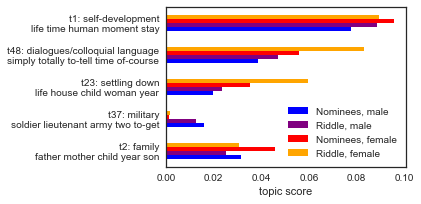

In [39]:
# Top 5 *most* different topics wrt gender in Nominees
x = meantopicsref.sort_values(by='diff', ascending=False).index[:5][::-1]
toptopicplot(x, 'topiccmpmax.pdf')

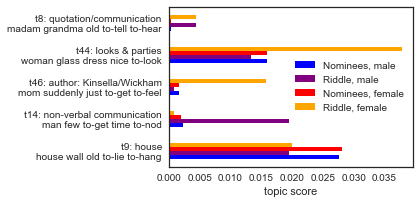

In [40]:
# Top 5 *least* different topics wrt gender in Nominees
x = meantopicsref.sort_values(by='diff', ascending=True).index[:5][::-1]
toptopicplot(x, 'topiccmpmin.pdf')

In [41]:
# scatter plot of visualizing the distribution of two topics
# across novels by both genders in the reference corpus
# (plot does not work when viewed with github)
def topicscatter(x, y):
    tmp = topicsref.reset_index().set_index(['gender','Label', 'chunk'], drop=False).mean(level=1)
    tmp['gender'] = mdr['Author gender']
    xx = topiclongnames[x]; yy = topiclongnames[y];
    scatterplot(tmp.rename(columns={x: xx, y: yy}), x=xx, y=yy, cat='gender', sizecat=None, labels=None,
                    alpha=0.5, figsize=(12, 10), markersize=100, graybg=False)

topicscatter('t23', 't48'); mpld3.display()

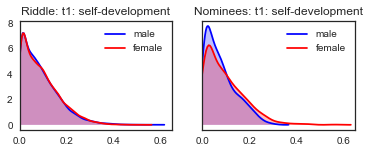

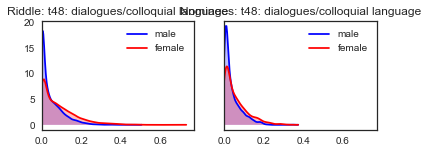

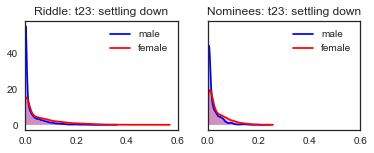

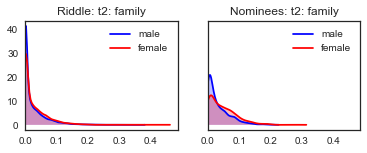

In [42]:
# kernel density estimation plots of distribution of a topic
def kde(topic):
    fig, axes = plt.subplots(
            nrows=1, ncols=2, figsize=(6, 2), sharex=True, sharey=True)
    for ax, df, label in zip(axes, (topicsriddle, topicsref), ('Riddle', 'Nominees')):
        tmp = df.reset_index().set_index(['gender','Label', 'chunk'], drop=False)
        sns.kdeplot(tmp.loc['male'][topic].reset_index(drop=True), ax=ax, shade=True, color='b', label='male')
        sns.kdeplot(tmp.loc['female'][topic].reset_index(drop=True), ax=ax, shade=True, color='r', label='female')
        ax.set_xlim(0)
        ax.set_title('%s: %s' % (label, ''.join(topiclongnames[topic])))

for a in ('t1', 't48', 't23', 't2'):
    kde(a)

             precision    recall  f1-score   support

     female       0.71      0.73      0.72      8262
       male       0.75      0.74      0.74      9183

avg / total       0.73      0.73      0.73     17445

classes: ['female' 'male']


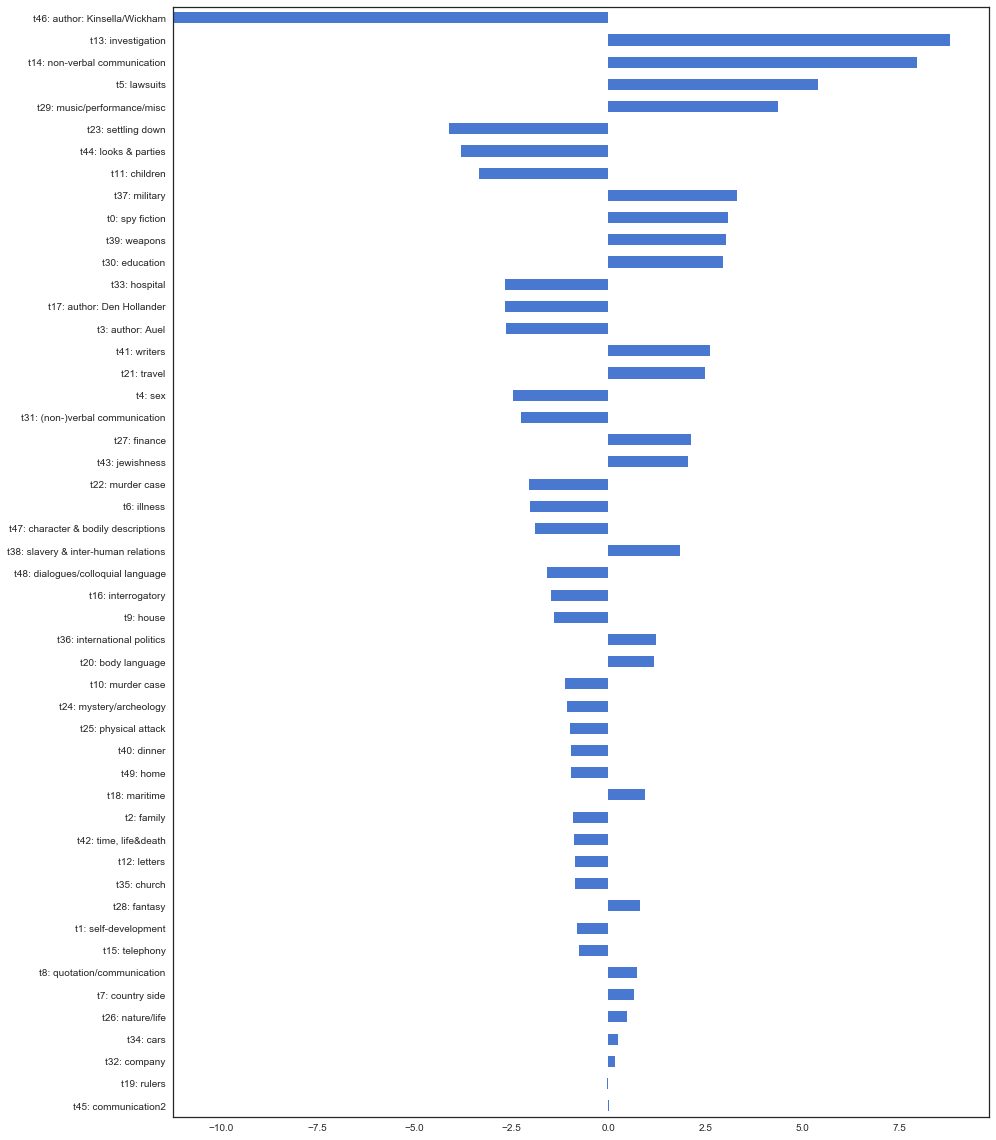

In [44]:
# Predict gender; train and test on Riddle corpus
e = topicsriddle[topicsriddle.gender != 'unknown/multiple']
# Collect author names so that the crossvalidation can take them into account
authors = e.index.get_level_values(0).str.split('_').str[0]
cv = model_selection.GroupKFold(n_splits=5)
clf = svm.LinearSVC(C=10, random_state=1)
X = e[[a for a in e.columns if a.startswith('t')]]
pred = model_selection.cross_val_predict(
        clf,
        X,
        e['gender'],
        cv=cv,
        groups=authors)
print(metrics.classification_report(e['gender'], pred))

train_index, test_index = next(iter(cv.split(X, groups=authors)))
data = e[[a for a in e.columns if a.startswith('t')]]
X_train, X_test = data.ix[train_index], data.ix[test_index]
y_train, y_test = e.ix[train_index]['gender'], e.ix[test_index]['gender']
clf.fit(X_train, y_train);

print('classes:', clf.classes_)
featweights = pandas.DataFrame(clf.coef_[:, :],
        columns=[topiclongnames[a] for a in e.columns if a.startswith('t')],
        index=['gender']).T
featweights['x'] = featweights.gender ** 2
featweights.sort_values(by='x').gender.plot(kind='barh', figsize=(14, 16))
plt.tight_layout()
# plt.savefig('/tmp/genderpred.pdf')

             precision    recall  f1-score   support

     female       0.56      0.29      0.39       791
       male       0.62      0.84      0.71      1097

avg / total       0.60      0.61      0.58      1888

classes: ['female' 'male']


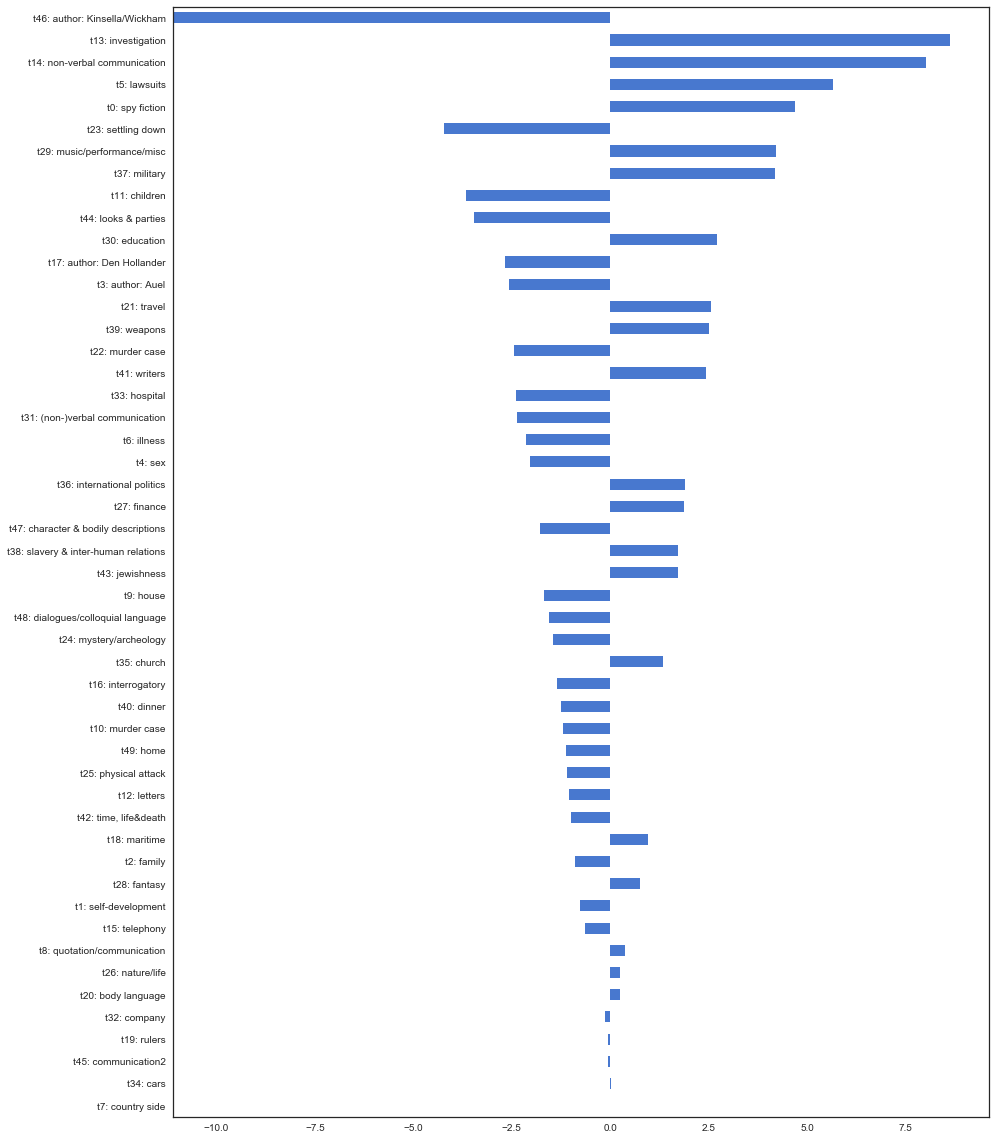

In [45]:
# Predict gender; train on Riddle topics, predict reference corpus
clf = svm.LinearSVC(C=10, random_state=1)
clf.fit(e[[a for a in topicsriddle.columns if a.startswith('t')]],
        e['gender'])
pred = clf.predict(topicsref[[a for a in topicsref.columns if a.startswith('t')]])
print(metrics.classification_report(topicsref['gender'], pred))

print('classes:', clf.classes_)
featweights = pandas.DataFrame(clf.coef_[:, :],
        columns=[topiclongnames[a] for a in e.columns if a.startswith('t')],
        index=['gender']).T
featweights['x'] = featweights.gender ** 2
featweights.sort_values(by='x').gender.plot(kind='barh', figsize=(14, 16))
plt.tight_layout()
# plt.savefig('/tmp/genderpred.pdf')

THE END